In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import pymc as pm

# TODO: add sigma for parameters so that I can save the tables

In [17]:
def load_data(n_years=None):
    df = pd.read_excel("./data/d18O NGRIP 21.04.24.xlsx", 
                       sheet_name="Raw Data", header=None, 
                       engine="openpyxl")
    
    df_data = df.iloc[10:6124,2:4]
    df_data.columns = ["Age", "d18o"]
    
    # set first year to 0 and choose years less than "n_years"
    df_data["Age"] -= min(df_data["Age"])
    if n_years is not None:
        df_data = df_data[df_data["Age"] <= n_years]
    
    # center data
    df_data["d18o"] -= np.mean(df_data["d18o"]) 
    
    t = df_data["Age"].values.astype("float")
    y = df_data["d18o"].values.astype("float")

    return t, y

def extract_harmonics(t, y, n_harmonics=3, n_samples=1000, n_tune=1000, 
                 n_chains=2, target_accept=0.95):
    residuals = y.copy()

    harmonics = []
    params = {"P": [], "A": [], "phi": []}
    for i in range(n_harmonics):
        print(60 * "-")
        text = f" Iteration number {i+1} of {n_harmonics} "
        left_text = " " * ((60 - len(text))//2)
        right_text = " " * (60 - len(left_text))
        print(f"{left_text}{text}{right_text}")
        print(60 * "-")
        
        P_guess = dominant_period(t, residuals)
        (A, P, phi), trace = fit_harmonic(t, residuals, P_guess, n_samples=n_samples, 
                                          n_tune=n_tune, n_chains=n_chains, target_accept=target_accept)
        harmonic = build_model(t, A, P, phi)
    
        residuals -= harmonic
        harmonics.append(harmonic)
        params["P"].append(P)
        params["A"].append(A)
        params["phi"].append(phi)

    final_model = np.sum(harmonics, axis=0)
    harmonics_params = pd.DataFrame(params).sort_values("P", ascending=False)

    if n_harmonics == 1:
        plt.figure(figsize=(7,7))
        pm.plot_trace(trace)
        plt.tight_layout()
    
    return final_model, harmonics_params, residuals

def dominant_period(t, y):
    # uniform t and y values for fourier transform
    dt  = np.median(np.diff(t))
    t_u = np.arange(t[0], t[-1] + dt, dt)
    y_u = np.interp(t_u, t, y)

    # get frequencies and find peaks
    frequencies = np.fft.rfftfreq(len(y_u), dt)
    ck = np.fft.rfft(y_u)
    abs_ck = abs(ck)
    peaks, _ = find_peaks(abs_ck)

    # find dominant period
    dominant_peak_idx = peaks[np.argmax(abs_ck[peaks])]
    dominant_period = 1 / frequencies[dominant_peak_idx]

    return dominant_period

def fit_harmonic(t, y, period_guess, n_samples=1000, n_tune=1000, 
                 n_chains=2, target_accept=0.95):

    y_std = y.std()

    with pm.Model() as harmonic:
        # priors
        A = pm.HalfNormal("A", sigma=2*y_std)
        P = pm.Normal("P", mu=period_guess, sigma=0.25*period_guess)
        phi = pm.Uniform("phi", lower=0, upper=2*np.pi)
        sig = pm.HalfNormal("sigma", sigma=y_std)

        mu = A * pm.math.cos(2*np.pi * t / P + phi)
        pm.Normal("y_obs", mu=mu, sigma=sig, observed=y)

        trace = pm.sample(n_samples, tune=n_tune, chains=n_chains,
                          cores=min(4, n_chains),
                          target_accept=target_accept,
                          return_inferencedata=True
                         )
        
    A_hat   = trace.posterior["A"].mean().item()
    P_hat   = trace.posterior["P"].mean().item()
    phi_hat = trace.posterior["phi"].mean().item()

    return (A_hat, P_hat, phi_hat), trace

def build_model(t, A, P, phi):
    return A * np.cos(2 * np.pi * t / P + phi)

def show_results(t, y, model, residuals=None):
    plt.figure(figsize=(8, 6))
    plt.plot(t, y,  lw=0.2, c="k", label="Original Data")
    plt.plot(t, model, "-", label="Bayesian Fit")
    if residuals is not None:
        plt.plot(t, residuals, lw=0.4, label="Residuals")
    
    plt.legend()
    plt.title("Bayesian Harmonic Fit")
    plt.xlabel("Time")
    plt.ylabel("Signal")
    plt.grid(True)
    plt.show()

In [18]:
t, y = load_data(n_years=30000)
model, params, residuals = extract_harmonics(t, y, n_harmonics=4, n_chains=4)

------------------------------------------------------------
                  Iteration number 1 of 4                                            
------------------------------------------------------------


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, P, phi, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


------------------------------------------------------------
                  Iteration number 2 of 4                                            
------------------------------------------------------------


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, P, phi, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


------------------------------------------------------------
                  Iteration number 3 of 4                                            
------------------------------------------------------------


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, P, phi, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


------------------------------------------------------------
                  Iteration number 4 of 4                                            
------------------------------------------------------------


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, P, phi, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.


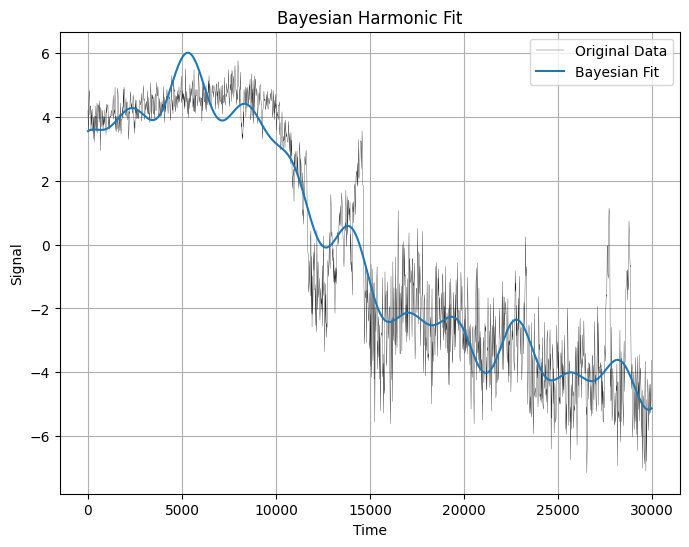

In [21]:
show_results(t, y, model)

In [89]:
n_years = 10000
n_harmonics = 30

In [91]:
# load data
df = pd.read_excel("./data/d18O NGRIP 21.04.24.xlsx", 
                   sheet_name="Raw Data", header=None, 
                   engine="openpyxl")

df_data = df.iloc[10:6124,2:4]
df_data.columns = ["Age", "d18o"]

# set first year to 0 and choose years less than "n_years"
df_data["Age"] -= min(df_data["Age"])
df_data = df_data[df_data["Age"] <= n_years]
# center data
df_data["d18o"] -= np.mean(df_data["d18o"]) 

t = df_data["Age"].values.astype("float")
y = df_data["d18o"].values.astype("float")

In [92]:
residuals = y.copy()

harmonics = []
params = {"P": [], "A": [], "phi": []}
for i in range(n_harmonics):
    print(f"***** Iteration number {i+1} of {n_harmonics} *******")
    
    P_guess = dominant_period(t, residuals)
    (A, P, phi), trace = fit_harmonic(t, residuals, period_guess=P_guess)
    harmonic = build_model(t, A, P, phi)

    residuals -= harmonic
    harmonics.append(harmonic)
    params["P"].append(P)
    params["A"].append(A)
    params["phi"].append(phi)

final_model = np.sum(harmonics, axis=0)

***** Iteration number 1 of 30 *******


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, P, phi, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 5 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


***** Iteration number 2 of 30 *******


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, P, phi, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 32 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


***** Iteration number 3 of 30 *******


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, P, phi, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 5 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


***** Iteration number 4 of 30 *******


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, P, phi, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 5 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


***** Iteration number 5 of 30 *******


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, P, phi, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 18 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


***** Iteration number 6 of 30 *******


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, P, phi, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 11 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


***** Iteration number 7 of 30 *******


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, P, phi, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 14 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


***** Iteration number 8 of 30 *******


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, P, phi, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 15 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


***** Iteration number 9 of 30 *******


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, P, phi, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 4 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


***** Iteration number 10 of 30 *******


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, P, phi, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 21 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


***** Iteration number 11 of 30 *******


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, P, phi, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 6 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


***** Iteration number 12 of 30 *******


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, P, phi, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 5 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


***** Iteration number 13 of 30 *******


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, P, phi, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 5 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


***** Iteration number 14 of 30 *******


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, P, phi, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 5 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


***** Iteration number 15 of 30 *******


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, P, phi, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 5 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


***** Iteration number 16 of 30 *******


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, P, phi, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 17 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


***** Iteration number 17 of 30 *******


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, P, phi, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 34 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


***** Iteration number 18 of 30 *******


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, P, phi, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 8 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


***** Iteration number 19 of 30 *******


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, P, phi, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 4 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


***** Iteration number 20 of 30 *******


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, P, phi, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 6 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


***** Iteration number 21 of 30 *******


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, P, phi, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 6 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


***** Iteration number 22 of 30 *******


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, P, phi, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 10 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


***** Iteration number 23 of 30 *******


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, P, phi, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 93 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


***** Iteration number 24 of 30 *******


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, P, phi, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 30 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


***** Iteration number 25 of 30 *******


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, P, phi, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 14 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


***** Iteration number 26 of 30 *******


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, P, phi, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 21 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


***** Iteration number 27 of 30 *******


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, P, phi, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 16 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


***** Iteration number 28 of 30 *******


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, P, phi, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 4 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


***** Iteration number 29 of 30 *******


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, P, phi, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 4 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


***** Iteration number 30 of 30 *******


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, P, phi, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 4 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


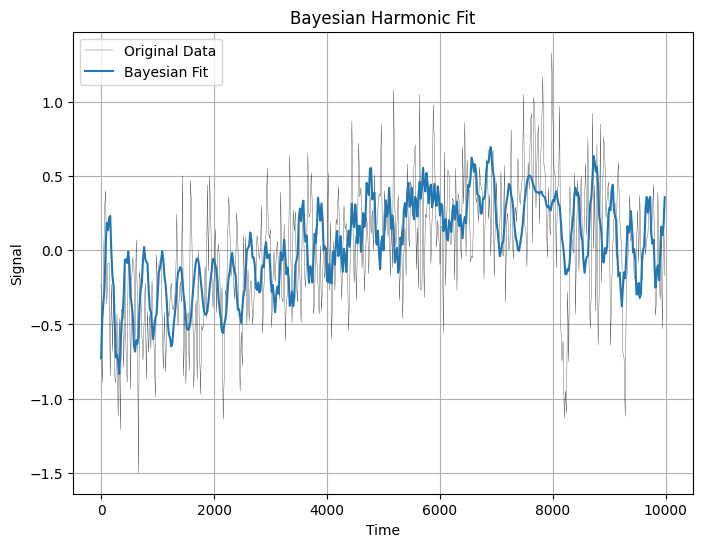

In [93]:
plt.figure(figsize=(8, 6))
plt.plot(t, y,  lw=0.2, c="k", label="Original Data")
plt.plot(t, final_model, "-", label="Bayesian Fit")
# plt.plot(t, residuals, lw=0.4, label="Residuals")
plt.legend()
plt.title("Bayesian Harmonic Fit")
plt.xlabel("Time")
plt.ylabel("Signal")
plt.grid(True)
plt.show()

if n_harmonics == 1:
    plt.figure(figsize=(7,7))
    pm.plot_trace(trace)
    plt.tight_layout()

In [94]:
harmonics_params = pd.DataFrame(params)
harmonics_params

,A,P,phi
0,0.332902,11667.200792,2.663657
1,0.081464,969.475182,1.526483
2,0.089594,1061.017999,4.427457
3,0.109235,993.868609,0.182380
4,0.061311,331.617954,4.073446
5,0.064471,372.884596,3.084784
6,0.060937,339.759209,4.521322
7,0.079022,338.479900,4.304956
8,0.167806,338.593876,1.336993
9,0.065635,340.172577,4.376897


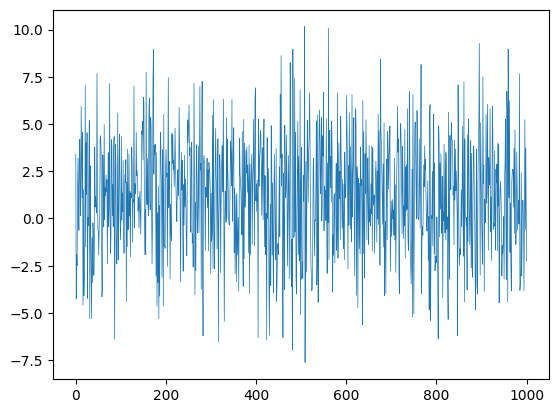

In [36]:
n = 1000
x = np.linspace(0,1000,n)
z = np.random.normal(1,3,n)
plt.plot(x,z, lw=0.5);

104
{'prominences': array([127.06622896,  59.0598529 , 121.2277987 ,  82.29890333,
       131.03522849, 142.53813248,  78.60135337, 144.99203791,
       186.83665114,  87.57644124,  66.65039537, 199.59731501,
       134.28336631,  64.85546916, 163.3252156 ,  57.07047397,
        79.59529336, 183.00634983,  68.37902282,  81.25420644,
        67.80112246,  96.21471259, 122.67307677, 104.24307854,
        65.25189988, 133.21456223, 149.6615194 , 110.30741768,
       143.97115434,  81.94883644,  76.28378625,  94.53873952,
       111.63038907, 203.87367163,  61.50897875,  98.36925315,
       118.5113264 ,  72.50870233, 157.42228576,  77.04029614,
        76.04935669,  80.18149127, 158.89579893, 152.11716949,
        80.28844231,  64.60724914, 128.25692837, 219.67377118,
        60.24729234,  77.6127664 ,  66.1931803 ,  90.91441895,
        78.06031399, 131.88861425,  86.63137001,  82.35853009,
       100.18205702, 129.01652178,  68.10774419,  77.75483861,
       105.64157637, 142.42170833, 

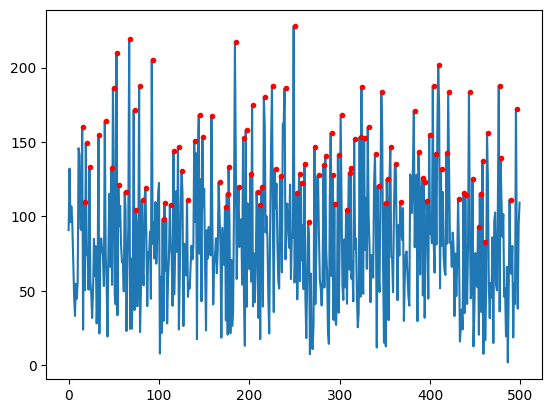

In [53]:
dx  = np.median(np.diff(x))
frequencies = np.fft.rfftfreq(len(z), dx)
ck = np.fft.rfft(z)
abs_ck = abs(ck)
peaks, prop = find_peaks(abs_ck, prominence=max(abs_ck)*0.05)
plt.plot(abs_ck[1:])
plt.plot(peaks, abs_ck[peaks], ".r");
print(len(peaks))
print(prop)

In [ ]:
dt  = np.median(np.diff(t))
t_u = np.arange(t[0], t[-1] + dt, dt)
y_u = np.interp(t_u, t, y)

# get frequencies and find peaks
frequencies = np.fft.rfftfreq(len(y_u), dt)
ck = np.fft.rfft(y_u)
abs_ck = abs(ck)
peaks, _ = find_peaks(abs_ck)

# find dominant period
dominant_peak_idx = peaks[np.argmax(abs_ck[peaks])]
dominant_period = 1 / frequencies[dominant_peak_idx]

In [ ]:
list_models = []
for i in range(len(params)):
    param_i = params[:i+1]
    P = param_i["P"].to_numpy()
    A = param_i["A"].to_numpy()
    phi = param_i["phi"].to_numpy()

    model1 = A[0] * np.cos(2 * np.pi * t / P[0] + phi[0])
    for j in range(1, len(P)):
        model1 += A[j] * np.cos(2 * np.pi * t / P[j] + phi[j])
    
    list_models.append(model1)

plt.figure(figsize=(8, 6))
# plt.plot(t, y,  lw=0.2, c="k", label="Original Data")
for model2 in list_models[10:11]:
    plt.plot(t, model2, "-", label="Bayesian Fit")

In [ ]:
plt.figure(figsize=(8, 6))
for i in range(len(params))[13:20]:
    A, P, phi = params.iloc[i][["A", "P", "phi"]]
    plt.plot(t, A * np.cos(2 * np.pi * t / P + phi))